In [1]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [6]:
# importing the "tarfile" module
import tarfile

# open file
file = tarfile.open('./flower_photos.tgz')

# extracting file
file.extractall('./')

file.close()

## Split Data Into Train Val & Test Folders

In [2]:
# Base Path for all files
data_dir = 'flower_photos'

## Data Visualization

In [3]:
import glob
daisy = glob.glob(data_dir+"/daisy/*")
dandelion = glob.glob(data_dir+"/dandelion/*")
roses = glob.glob(data_dir+"/roses/*")
sunflowers = glob.glob(data_dir+"/sunflowers/*")
tulips = glob.glob(data_dir+"/tulips/*")

print(len(daisy))
print(len(dandelion))
print(len(roses))
print(len(sunflowers))
print(len(tulips))

633
898
641
699
799


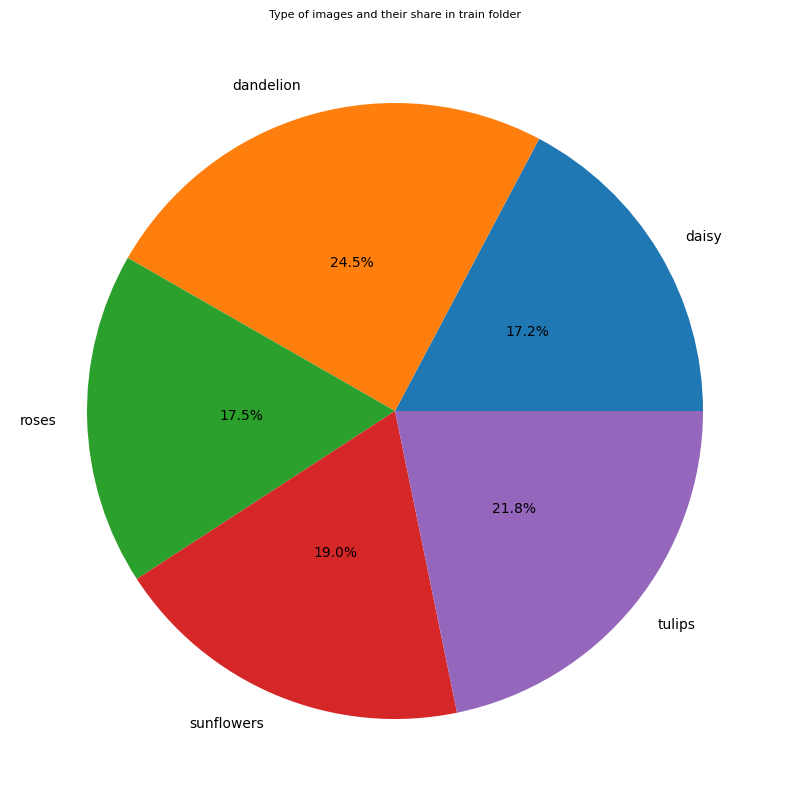

In [4]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([len(daisy), len(dandelion),len(roses), len(sunflowers), len(tulips)]), autopct="%.1f%%", explode=[0,0,0,0,0], labels=["daisy", "dandelion","roses", "sunflowers","tulips",], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=8);

## Upload Data In s3

In [10]:
# !pip install sagemaker

In [11]:
import sagemaker
import boto3
import pandas as pd

sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = 'flower-classification-app1' # Mention the created S3 bucket name here
print("Using bucket " + bucket)

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\TEXON WARE\AppData\Local\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\TEXON WARE\AppData\Local\sagemaker\sagemaker\config.yaml
Using bucket flower-classification-app1


In [12]:
# send data to S3. SageMaker will take training data from s3
sk_prefix = "sagemaker/Flower_classification/dataset"
datapath = sess.upload_data(
    path=data_dir, bucket=bucket, key_prefix=sk_prefix
)
print(datapath)

s3://flower-classification-app1/sagemaker/Flower_classification/dataset


In [5]:
datapath = 's3://flower-classification-app1/sagemaker/Flower_classification/dataset'
# validation_input_path = 's3://sagemaker-us-east-1-811710284692/snapCycle-classification/validation'
# print(training_input_path)
# print(validation_input_path)

## Start Training job

In [15]:
from sagemaker.tensorflow import TensorFlow
from keras.preprocessing import image
import time
# install dependecies in tensorflow container.
env = {
    'SAGEMAKER_REQUIREMENTS': 'requirements.txt', # path relative to `source_dir` below.
}

#hyperperameter tuining
hyperparameters={'epochs': 3,
                 'batch-size': 32} 

# role = sagemaker.get_execution_role()
tf_estimator = TensorFlow(entry_point='train.py',
                          source_dir='src',
                          role="arn:aws:iam::220544705075:role/agriculture",
                          instance_count=1, 
                          instance_type='ml.m5.large',     # $0.922 per hours
                          framework_version='2.3',
                          base_job_name="Flower-classification",
                          py_version='py37',
                          script_mode=True,
                          use_spot_instances = True,
                          max_wait = 7200,
                          max_run = 3600,
                          hyperparameters = hyperparameters)

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\TEXON WARE\AppData\Local\sagemaker\sagemaker\config.yaml


In [16]:
tf_estimator.hyperparameters()

{'epochs': '3', 'batch-size': '32', 'model_dir': 'null'}

In [17]:
tf_estimator.fit({'training':datapath})

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: Flower-classification-2023-10-06-09-24-54-222


2023-10-06 09:25:04 Starting - Starting the training job...
2023-10-06 09:25:18 Starting - Preparing the instances for training.........
2023-10-06 09:27:07 Downloading - Downloading input data......
2023-10-06 09:28:38 Training - Training image download completed. Training in progress..2023-10-06 09:28:41.006138: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-10-06 09:28:41.006350: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-10-06 09:28:41.036969: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-10-06 09:28:42,615 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2023-10-06 09:28:42,623 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-10-06 09

## Deploy Model

In [18]:
%%time
tf_endpoint_name = 'flower-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

#tf_predictor = tf_estimator.deploy(initial_instance_count=1,
#                                   instance_type='ml.p2.xlarge')      # $1.361/hour 

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.t2.medium',        # $0.115/hour 
                                   endpoint_name=tf_endpoint_name) 

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: Flower-classification-2023-10-06-10-08-59-932
INFO:sagemaker:Creating endpoint-config with name flower-2023-10-06-10-08-59
INFO:sagemaker:Creating endpoint with name flower-2023-10-06-10-08-59


-----!CPU times: total: 172 ms
Wall time: 3min 8s


In [23]:
# tf_predictor.endpoint
# tf_predictor = 'flower-2023-10-03-10-15-33'

## Prediction

{'1-PET': 0, '2-HDPE': 1}

In [19]:
from keras.preprocessing import image
path_HDPE='https://images.all-free-download.com/images/graphiclarge/background_bloom_blossom_celebration_ceremony_603818.jpg'
# path_pet='out/test/1-PET/0217024149.jpg'

In [20]:
import os
import requests
from io import BytesIO
from PIL import Image
url_pet = path_HDPE
response = requests.get(url_pet)
img1 = Image.open(BytesIO(response.content))
img1.save('./test.jpg')
# print(os.listdir('/tmp/'))
    
file_name = 'test.jpg'
print(file_name)

test.jpg


In [21]:
# img=image.load_img(path_pet, target_size=(300, 220))
# img=image.load_img(file_name, target_size=(300, 300))
# x = np.asarray(img) / 255
# x=np.expand_dims(x, axis=0)
# images = np.vstack([x])


test_image = Image.open(file_name)
test_image = test_image.resize((300, 300))
test_image = np.asarray(test_image)/255.0
test_image=np.expand_dims(test_image, axis=0)

In [22]:
test_image.shape

(1, 300, 300, 3)

In [23]:
# !pip install sagemaker

In [24]:
# Default format for inference is JSON
# from sagemaker.serializers import CSVSerializer
# from sagemaker.predictor import json_serializer
# tf_predictor.content_type = 'application/x-image',
# tf_predictor.serializer =  json_serializer

In [25]:
predictions2 =tf_predictor.predict(test_image)
# new_list = list(predictions2.values())
# new_list = np.array(new_list)
print(predictions2['predictions'][0])
# if predictions2['predictions'][0][0]<0.5:
#     print(path + " is a PET")
# else:
#     print(path + " is a HDPE")
# predicted_label = new_list.argmax(axis=1)
# print('Predicted labels are: {}'.format(predicted_label))

[2.07437279e-05, 6.90342802e-07, 0.99966383, 9.36044944e-06, 0.000305376161]


In [87]:
predictions2

{'predictions': [[1.0]]}

## Delete Endpoint